In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import yfinance as yf

In [6]:
# Define the ticker symbol for Apple
ticker = 'AAPL'

# Get the data of the stock
data = yf.download(ticker, start="2020-01-01", )
print(data.shape)

[*********************100%***********************]  1 of 1 completed

(1222, 6)


In [7]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02 00:00:00+00:00,72.876099,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03 00:00:00+00:00,72.167603,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06 00:00:00+00:00,72.742645,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07 00:00:00+00:00,72.400551,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08 00:00:00+00:00,73.565193,75.797501,76.110001,74.290001,74.290001,132079200


### PCA weights from a risk distribution R

In [8]:
def pcaWeights(cov, riskDist=None, riskTarget=1.):
    eVal, eVec = np.linalg.eig(cov)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1
    loads = riskTarget * (riskDist/eVal)**.5
    wghts = np.dot(eVec, loads.reshape(-1, 1))
    return wghts

In [9]:
matrixSize = 3 
np.random.seed(0)
A = np.random.rand(matrixSize, matrixSize)
B = np.dot(A, A.transpose())
pcaWeights(B)

array([[ 4.91041938],
       [-3.132718  ],
       [-1.73855105]])

#### The symmetric CUSUM Filter

In [10]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i].values[0]), min(0, sNeg + diff.loc[i].values[0])
        if sPos > h:
            sPos = 0
            tEvents.append(i)
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
    return tEvents

In [11]:
prices = data['Close']
events = getTEvents(prices, 5)

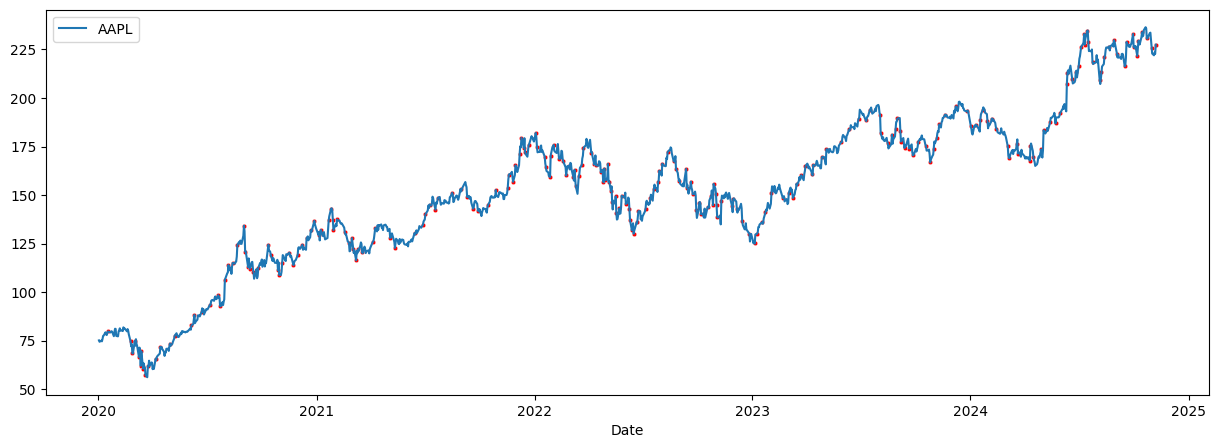

In [12]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Close'])
sns.scatterplot(x=pd.Series(events),y=data.loc[events,'Close'].values.reshape(-1), s=10, color="red")
plt.show()

## Exercise

In [13]:
## get the data
es_data = yf.download("ES=F", period="1Y", interval="1d") 

[*********************100%***********************]  1 of 1 completed


In [14]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ES=F,ES=F,ES=F,ES=F,ES=F,ES=F
Date,,,,,,
2023-11-07 00:00:00+00:00,4396.00,4396.00,4403.25,4366.00,4380.00,1371257
2023-11-08 00:00:00+00:00,4399.50,4399.50,4407.75,4375.00,4397.50,1390288
2023-11-09 00:00:00+00:00,4362.25,4362.25,4413.00,4357.75,4393.25,1972630
2023-11-10 00:00:00+00:00,4430.50,4430.50,4435.50,4354.25,4364.50,1752002
2023-11-13 00:00:00+00:00,4425.25,4425.25,4436.75,4407.25,4425.75,1276182


In [15]:
es_data.columns = es_data.columns.get_level_values(0)

In [59]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-11-07 00:00:00+00:00,4396.00,4396.00,4403.25,4366.00,4380.00,1371257
2023-11-08 00:00:00+00:00,4399.50,4399.50,4407.75,4375.00,4397.50,1390288
2023-11-09 00:00:00+00:00,4362.25,4362.25,4413.00,4357.75,4393.25,1972630
2023-11-10 00:00:00+00:00,4430.50,4430.50,4435.50,4354.25,4364.50,1752002
2023-11-13 00:00:00+00:00,4425.25,4425.25,4436.75,4407.25,4425.75,1276182


In [105]:
def advanced_bars(series, h, bar_type = 'Volume'):
    df = pd.DataFrame()
    temp_data = series.reset_index()
    current_vol = 0
    for i in range(len(temp_data)):
        if current_vol == 0:
                date, cum_high,cum_low,cum_open,cum_close,cum_adj_close = temp_data.iloc[i]['Date'],temp_data.iloc[i]['High'],temp_data.iloc[i]['Low'],temp_data.iloc[i]['Open'],temp_data.iloc[i]['Close'],temp_data.iloc[i]['Adj Close']
        cum_high, cum_low = max(cum_high, temp_data.iloc[i]['High']), min(cum_low, temp_data.iloc[i]['Low'])
        if bar_type == 'Volume':
            current_vol += temp_data.iloc[i]['Volume']
        elif bar_type == 'Dollar':
            current_vol += temp_data.iloc[i]['Volume'] * temp_data.iloc[i]['Close']
        elif bar_type == 'Tick':
            current_vol += 1
        else:
            raise ValueError("bar_type Wrong! Please enter correct bar_type: Volume, Dollar or Tick")

        if (current_vol >= h):
            cum_close = temp_data.iloc[i][ 'Close']
            cum_adj_close = temp_data.iloc[i]['Adj Close']
            temp = pd.DataFrame([[date, cum_adj_close, cum_close, cum_high, cum_low, cum_open, current_vol]], columns = ['Date','Adj Close','Close','High','Low','Open','Cum '+bar_type])
            current_vol = 0
            df = pd.concat([df, temp], axis=0)
    return df

In [113]:
advanced_bars(es_data, h=2, bar_type='Tick').head(10)

,Date,Adj Close,Close,High,Low,Open,Cum Tick
0,2023-11-07 00:00:00+00:00,4399.50,4399.50,4407.75,4366.00,4380.00,2
0,2023-11-09 00:00:00+00:00,4430.50,4430.50,4435.50,4354.25,4393.25,2
0,2023-11-13 00:00:00+00:00,4511.00,4511.00,4524.25,4407.25,4425.75,2
0,2023-11-15 00:00:00+00:00,4523.25,4523.25,4541.25,4501.75,4515.50,2
0,2023-11-17 00:00:00+00:00,4562.25,4562.25,4571.00,4512.75,4527.75,2
0,2023-11-21 00:00:00+00:00,4567.25,4567.25,4580.50,4536.75,4561.75,2
0,2023-11-23 00:00:00+00:00,4568.25,4568.25,4574.00,4562.00,4564.00,2
0,2023-11-27 00:00:00+00:00,4563.00,4563.00,4577.25,4547.00,4568.50,2
0,2023-11-29 00:00:00+00:00,4576.75,4576.75,4597.00,4544.75,4564.00,2
0,2023-12-01 00:00:00+00:00,4576.50,4576.50,4607.75,4553.50,4571.75,2


In [114]:
advanced_bars(es_data, h=2000000, bar_type='Volume').head(10)

,Date,Adj Close,Close,High,Low,Open,Cum Volume
0,2023-11-07 00:00:00+00:00,4399.50,4399.50,4407.75,4366.00,4380.00,2761545
0,2023-11-09 00:00:00+00:00,4430.50,4430.50,4435.50,4354.25,4393.25,3724632
0,2023-11-13 00:00:00+00:00,4511.00,4511.00,4524.25,4407.25,4425.75,3178029
0,2023-11-15 00:00:00+00:00,4523.25,4523.25,4541.25,4501.75,4515.50,3065186
0,2023-11-17 00:00:00+00:00,4562.25,4562.25,4571.00,4512.75,4527.75,2552702
0,2023-11-21 00:00:00+00:00,4567.25,4567.25,4580.50,4536.75,4561.75,2505305
0,2023-11-23 00:00:00+00:00,4561.00,4561.00,4574.00,4552.00,4564.00,3100551
0,2023-11-28 00:00:00+00:00,4559.25,4559.25,4597.00,4547.00,4561.50,3033517
0,2023-11-30 00:00:00+00:00,4576.75,4576.75,4579.50,4544.75,4562.25,2056268
0,2023-12-01 00:00:00+00:00,4576.50,4576.50,4607.75,4553.50,4571.75,3733142


In [106]:
advanced_bars(es_data, h=2000000*50000, bar_type='Dollar')

,Date,Adj Close,Close,High,Low,Open,Cum Dollar
0,2023-11-07 00:00:00+00:00,4563.00,4563.00,4580.50,4354.250000,4380.00,1.003550e+11
0,2023-11-29 00:00:00+00:00,4793.00,4793.00,4802.25,4544.750000,4564.00,1.024148e+11
0,2023-12-19 00:00:00+00:00,4815.50,4815.50,4841.50,4702.000000,4790.50,1.069647e+11
0,2024-01-12 00:00:00+00:00,4928.50,4928.50,4963.75,4746.250000,4811.25,1.079629e+11
0,2024-02-02 00:00:00+00:00,5097.75,5097.75,5107.75,4925.750000,4952.75,1.046534e+11
0,2024-02-23 00:00:00+00:00,5123.00,5123.00,5193.00,5060.000000,5094.25,1.000548e+11
0,2024-03-12 00:00:00+00:00,5266.50,5266.50,5333.50,5101.669922,5129.00,1.030618e+11
0,2024-04-04 00:00:00+00:00,5049.00,5049.00,5308.50,5038.500000,5270.75,1.072813e+11
0,2024-04-19 00:00:00+00:00,5213.75,5213.75,5226.75,4963.500000,5047.25,1.032113e+11
0,2024-05-08 00:00:00+00:00,5253.00,5253.00,5368.25,5188.750000,5211.75,1.056057e+11
